In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

# Regression Analysis: Seasonal Effects with Sklearn Linear Regression
In this notebook, you will build a SKLearn linear regression model to predict hp ("Close") returns with *lagged* hp returns. 

In [8]:
# Futures contract on the hp price:

hp = pd.read_csv(
    Path("hp.csv"), index_col="Date",parse_dates=True
)
hp.tail()

,Close,Volume,Open,High,Low
Date,,,,,
2019-12-10,20.20,11302750.0,19.97,20.27,19.97
2019-12-11,20.07,15139510.0,20.20,20.23,19.94
2019-12-12,20.43,14799340.0,19.94,20.50,19.94
2019-12-13,20.35,8693891.0,20.37,20.53,20.26
2019-12-16,20.52,8720853.0,20.40,20.69,20.38


In [11]:
# Trim the dataset to begin on December 15, 2014
hp = hp.loc["2014-12-17" :, :]
hp.head()

,Close,Volume,Open,High,Low
Date,,,,,
2014-12-17,17.88,11527190.0,17.59,17.93,17.53
2014-12-18,18.42,12415970.0,18.08,18.43,18.02
2014-12-19,18.46,18558860.0,18.40,18.62,18.35
2014-12-22,18.41,10806910.0,18.49,18.69,18.28
2014-12-23,18.67,9664837.0,18.47,18.78,18.47


# Data Preparation

### Returns

In [12]:
# Create a series using "Close" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
hp['Return'] = hp.Close.pct_change() * 100
hp = hp.replace(-np.inf, np.nan).dropna()
hp=hp.replace('$', '')
hp.tail()

,Close,Volume,Open,High,Low,Return
Date,,,,,,
2019-12-10,20.20,11302750.0,19.97,20.27,19.97,-1.319003
2019-12-11,20.07,15139510.0,20.20,20.23,19.94,-0.643564
2019-12-12,20.43,14799340.0,19.94,20.50,19.94,1.793722
2019-12-13,20.35,8693891.0,20.37,20.53,20.26,-0.391581
2019-12-16,20.52,8720853.0,20.40,20.69,20.38,0.835381


### Lagged Returns 

In [13]:
# Create a lagged return using the shift function
hp['Lagged_Return'] = hp.Return.shift()
hp = hp.replace(-np.inf, np.nan).dropna()
hp.tail()

,Close,Volume,Open,High,Low,Return,Lagged_Return
Date,,,,,,,
2019-12-10,20.20,11302750.0,19.97,20.27,19.97,-1.319003,-0.146341
2019-12-11,20.07,15139510.0,20.20,20.23,19.94,-0.643564,-1.319003
2019-12-12,20.43,14799340.0,19.94,20.50,19.94,1.793722,-0.643564
2019-12-13,20.35,8693891.0,20.37,20.53,20.26,-0.391581,1.793722
2019-12-16,20.52,8720853.0,20.40,20.69,20.38,0.835381,-0.391581


### Train Test Split

In [14]:
# Create a train/test split for the data using 2018-2019 for testing and the rest for training
train = hp[:'2018']
test = hp['2018':]


In [15]:
# Create four dataframes:
# X_train (training set using just the independent variables), X_test (test set of of just the independent variables)
# Y_train (training set using just the "y" variable, i.e., "Futures Return"), Y_test (test set of just the "y" variable):
X_train = train["Lagged_Return"].to_frame()
X_test = test["Lagged_Return"].to_frame()
y_train = train["Return"]
y_test = test["Return"]

In [16]:
X_train.head()

,Lagged_Return
Date,
2014-12-19,3.020134
2014-12-22,0.217155
2014-12-23,-0.270856
2014-12-24,1.412276
2014-12-26,0.428495


# Linear Regression Model

In [17]:
# Create a Linear Regression model and fit it to the training data
from sklearn.linear_model import LinearRegression

# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

# Make predictions using the Testing Data

Note: We want to evaluate the model using data that it has never seen before, in this case: X_test.

In [18]:
# Make a prediction of "y" values using just the test dataset
predictions = model.predict(X_test)

In [19]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = y_test.to_frame()
Results["Predicted Return"] = predictions
#Results.head()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000277F9D0DFD0>,
      dtype=object)

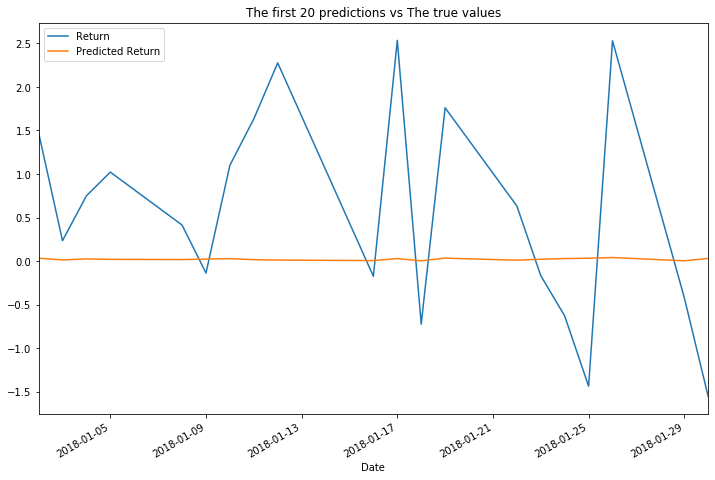

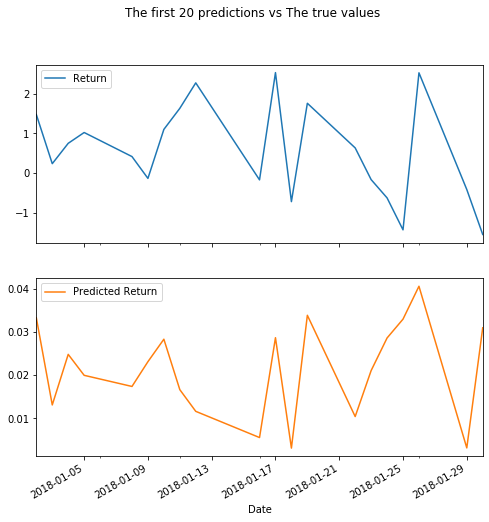

In [20]:
# Plot the first 20 predictions vs the true values
Results[:20].plot(title='The first 20 predictions vs The true values', figsize=(12, 8))
Results[:20].plot(subplots=True, figsize=(8, 8), title='The first 20 predictions vs The true values')

# Out-of-Sample Performance

Evaluate the model using "out-of-sample" data (X_test and y_test)

In [21]:
from sklearn.metrics import mean_squared_error
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
mse = mean_squared_error(
    Results["Return"],
    Results["Predicted Return"]
)

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
rmse = np.sqrt(mse)
print(f"Out-of-Sample Root Mean Squared Error (RMSE): {rmse}")

Out-of-Sample Root Mean Squared Error (RMSE): 1.8804281639233602


# In-Sample Performance

Evaluate the model using in-sample data (X_train and y_train)

In [22]:
# Construct a dataframe using just the "y" training data:
in_sample_results = y_train.to_frame()

# Add a column of "in-sample" predictions to that dataframe:  
in_sample_results["In-sample Predictions"] = model.predict(X_train)

# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
in_sample_mse = mean_squared_error(
    in_sample_results["Return"],
    in_sample_results["In-sample Predictions"]
)

# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
in_sample_rmse = np.sqrt(in_sample_mse)
print(f"In-sample Root Mean Squared Error (RMSE): {in_sample_rmse}")

In-sample Root Mean Squared Error (RMSE): 1.803123526177073


# Conclusions

YOUR CONCLUSIONS HERE!

### lower RMSE is the the sign of fitness of our model, that is why this model perform better with in-Sample data utilization! 